In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import math
import pandas as pd

In [2]:
"""
深度マップを、指定した高さに量子化する関数(depth:深度マップ、ブロックの最大の高さn)
"""
def posterization(depth, n):
    depth = 255-depth
    th_bin, depth_bin = cv2.threshold(depth,0,255,cv2.THRESH_OTSU)
    ran = th_bin/n
    out = np.ones_like(depth)
    for i in range(n-1):
        #out = np.where( (i*ran < img)&(img<=(i+1)*ran), (i+1)*(255//n), out )
        out = np.where( (i*ran<=depth)&(depth<(i+1)*ran), n-i, out )
    return out

In [3]:
"""使用するブロックの色を表示する関数(color_dic={"color_name":[R,G,B]})"""
def show_col_list(color_dic):
    color_rgb = np.array([[c_l] for c_l in color_dic.values()]).astype(np.uint8)
    color_rgb = color_rgb.transpose(1, 0, 2)
    plt.figure(figsize=(20,10))
    plt.imshow(color_rgb[...,::-1])
    plt.show()

In [4]:
"""LEGOブロックの色のみに変換する関数(モザイクがかけられたRGB画像、使用するブロックの色の辞書)"""
def change_coler(img_rgb, color_dic):
    Height, Width = img_rgb.shape[:2]
    img_lab = cv2.cvtColor(img_rgb, cv2.COLOR_BGR2LAB)
    color_dic_rgb = np.array([[c_l] for c_l in color_dic.values()]).astype(np.uint8)
    color_dic_rgb = color_dic_rgb.transpose(1, 0, 2)
    color_dic_lab = cv2.cvtColor(color_dic_rgb, cv2.COLOR_BGR2LAB).astype(np.int16)
    
    
    img_L, img_A, img_B = img_lab[...,0], img_lab[...,1], img_lab[...,2]
    list_L, list_A, list_B = color_dic_lab[...,0], color_dic_lab[...,1], color_dic_lab[...,2]
    list_L, list_A, list_B = np.ravel(list_L), np.ravel(list_A), np.ravel(list_B)
    
    """
    RGBで比較
    img_L, img_A, img_B = img_rgb[...,0], img_rgb[...,1], img_rgb[...,2]
    list_L, list_A, list_B = col_list_rgb[...,0], col_list_rgb[...,1], col_list_rgb[...,2]
    list_L, list_A, list_B = np.ravel(list_L), np.ravel(list_A), np.ravel(list_B)
    """
    #各ブロックの色との差を格納
    diff = np.zeros((Height, Width, len(color_dic)))
    #一番差が小さいブロックの色のインデックスを格納
    min_col_num = np.zeros((Height, Width))

    for h in range(Height):
        for w in range(Width):
            diff[h,w] = ((float(img_L[h,w]) - list_L)**2 + (float(img_A[h,w]) - list_A)**2 + (float(img_B[h,w]) - list_B)**2)**0.5
            min_col_num[h,w] = np.argmin(diff[h,w])
    
    col_keys = list(color_dic.keys())
    Out = np.zeros_like(img_rgb)
    for h in range(Height):
        for w in range(Width):
            Out[h,w] = color_dic[col_keys[int(min_col_num[h,w])]]
    
    return Out

In [5]:
"""RGBとdepth情報をまとめたnumpy配列を作製する関数"""
def create_rgb_depth_map(rgb, depth):
    depth = depth[:,:,np.newaxis]
    print(rgb.shape)
    print(depth.shape)
    Out = np.concatenate([rgb,depth],axis=2)
    return Out

"""depth情報と色情報をそれぞれCSVファイルに保存する"""
def create_csv_file(rgb, depth):
    Height, Width = rgb.shape[:2]
    rgb_map = [[] for _ in range(Height)]
    for h in range(Height):
        for w in range(Width):
            rgb_merge = hex(rgb[h,w,2])[2:] + hex(rgb[h,w,1])[2:] + hex(rgb[h,w,0])[2:]
            rgb_map[h].append("0x" + rgb_merge)
    
    df_rgb = pd.DataFrame(rgb_map)
    df_rgb.to_csv("rgb_map.csv", header=False, index=False)
    df_depth = pd.DataFrame(depth)
    df_depth.to_csv("depth_map.csv", header=False, index=False)

In [6]:
"""
元画像（RGB画像および深度マップを入力）
LEGOARTの幅resize_wを指定
ブロックの最大の高さblock_hを指定
使用するブロックの色の辞書
"""
def main(img_rgb, img_depth, resize_w, block_h, color_dic):
    Height, Width = img_rgb.shape[:2]
    ratio = resize_w/Width
    resize_rgb = cv2.resize(img_rgb, None, fx=ratio, fy=ratio, interpolation=cv2.INTER_NEAREST)
    
    resize_depth = cv2.resize(img_depth, None, fx=ratio, fy=ratio, interpolation=cv2.INTER_NEAREST)
    depth_post = posterization(resize_depth, block_h)
    
    LEGO_rgb = change_coler(resize_rgb, color_dic)
    
    rgb_depth_array = create_rgb_depth_map(LEGO_rgb, depth_post)
    """create_csv_file(LEGO_rgb, depth_post)"""
    
    """LEGOブロックの色のみの画像、指定した高さの深度マップ、rgb_depth情報を含んだnumpy配列"""
    return LEGO_rgb, depth_post, rgb_depth_array

In [7]:
def show_image(image_original, depth_map, lego_rgb, lego_depth):
    plt.figure(figsize=(20,15))
    plt.subplot(221)
    plt.imshow(image_original[...,::-1])
    plt.subplot(222)
    plt.imshow(depth_map, cmap="gray")
    plt.subplot(223)
    plt.imshow(lego_rgb[...,::-1])
    plt.subplot(224)
    plt.imshow(lego_depth, cmap="gray")
    plt.show()

In [8]:
COLOR_DIC = {'0 White': [242, 243, 242], '1 Tan': [111, 160, 176], '2 Light Green': [168, 217, 173], '3 Maersk Blue': [195, 146, 53], '4 Pink': [255, 217, 171],
             '5 Nougat': [104, 145, 208], '6 Red': [9, 26, 201], '7 Blue': [191, 85, 0], '8 Yellow': [55, 205, 242], '9 Black': [29, 19, 5],
             '10 Green': [65, 120, 35], '11 Md,Green': [117, 196, 127], '12 Bt,Green': [65, 171, 88], '13 Dark Orange': [0, 85, 169],
             '14 Light Violet': [226, 202, 201], '15 Md,Blue': [219, 147, 90], '16 Md,Orange': [11, 167, 255], '17 Orange': [24, 138, 254],
             '18 Blue-Violet': [202, 116, 104], '19 Light Turquoise': [175, 165, 85], '20 Lime': [11, 233, 187], '21 Magenta': [118, 31, 144],
             '22 Sand Blue': [161, 116, 96], '23 Md,Nougat': [42, 112, 204], '24 Dark Tan': [115, 138, 149], '25 Dark Blue': [99, 52, 10],
             '26 Dark Green': [50, 70, 24], '27 Sand Green': [172, 188, 160], '28 Dark Red': [15, 14, 114], '29 Bt,Lt Orange': [61, 187, 248],
             '30 Reddish Brown': [18, 42, 88], '31 Light Bluish Gray': [169, 165, 160], '32 Dark Bluish Gray': [104, 110, 108],
             '33 Very Lt, Bluish Gray': [224, 227, 230], '34 Bt, Lt Blue': [233, 195, 159], '35 Dark Pink': [160, 112, 200],
             '36 Bright Pink': [200, 173, 228], '37 Bt,Lt Yellow': [58, 240, 255], '38 Dark Purple': [145, 54, 63], '39 Light Nougat': [179, 215, 246],
             '40 Dark Brown': [0, 33, 53], '41 Light Aqua': [234, 242, 211], '42 Md,Lavender': [185, 110, 160], '43 Lavender': [222, 164, 205],
             '44 Coral': [80, 127, 255]
            }

## 使用するブロックの色を指定する

In [9]:
def choose_color(COLOR_DIC):
    print(COLOR_DIC)
    show_col_list(COLOR_DIC)
    """keyのみのリストを作成"""
    key_list = []
    for i, key in enumerate(COLOR_DIC):
        key_list.append(key)
    """使用する色の番号を入力"""
    use_color_num = list(map(int, input().split()))
    USE_COLOR_DIC = {}
    for num in use_color_num:
        key = key_list[num]
        USE_COLOR_DIC[key] = COLOR_DIC[key]
        
    return USE_COLOR_DIC

## ミッキーマウス

(103, 100, 3)
(103, 100, 1)


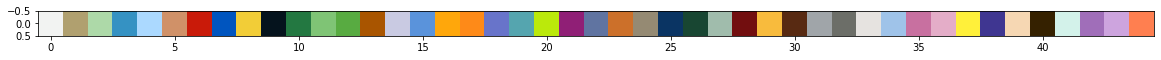

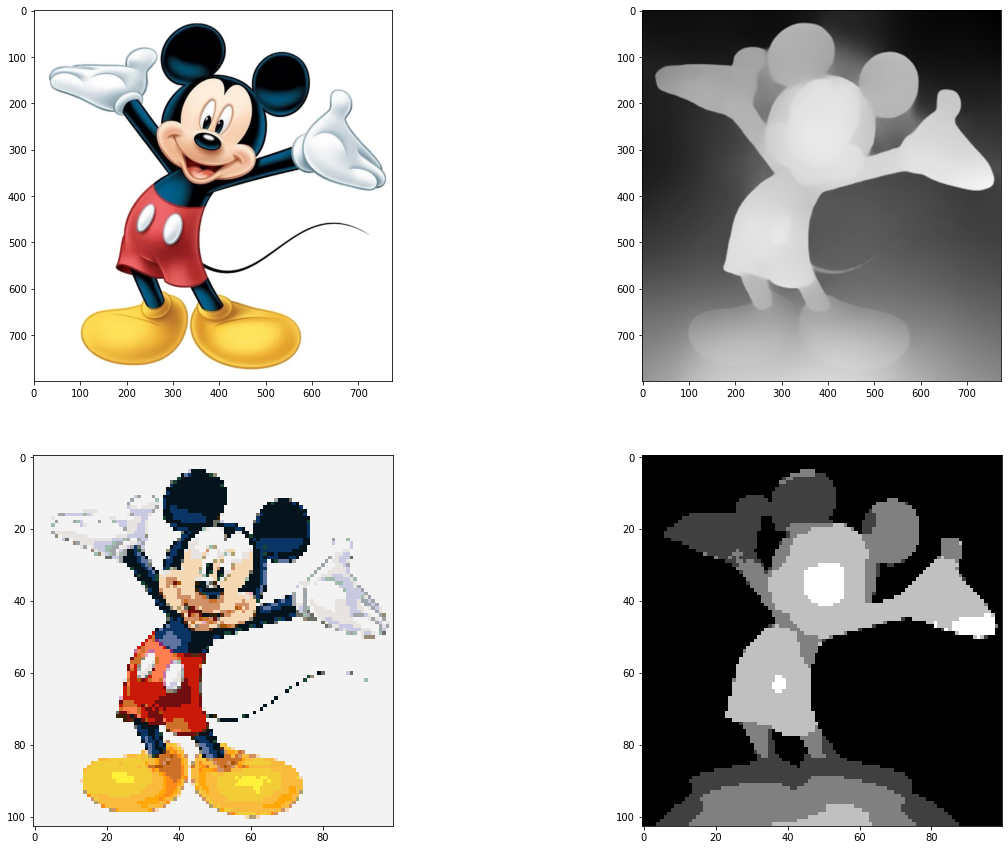

'npyファイルの保存'

In [10]:
image_original = cv2.imread("./data/img/MM_rgb.png")
depth_map = cv2.imread("./data/img/MM_depth.png", 0)
resize_w=100
block_h=5
lego_rgb, lego_depth, rgb_depth_array = main(image_original, depth_map, resize_w, block_h, COLOR_DIC)
show_col_list(COLOR_DIC)
show_image(image_original, depth_map, lego_rgb, lego_depth)
"""npyファイルの保存"""
#np.save("./data/npy/MM_depth", rgb_depth)

## アイアンマン

libpng warning: extreme cHRM chunk cannot be converted to tristimulus values
libpng warning: Invalid cHRM red point


(55, 50, 3)
(55, 50, 1)


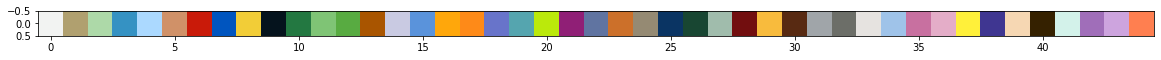

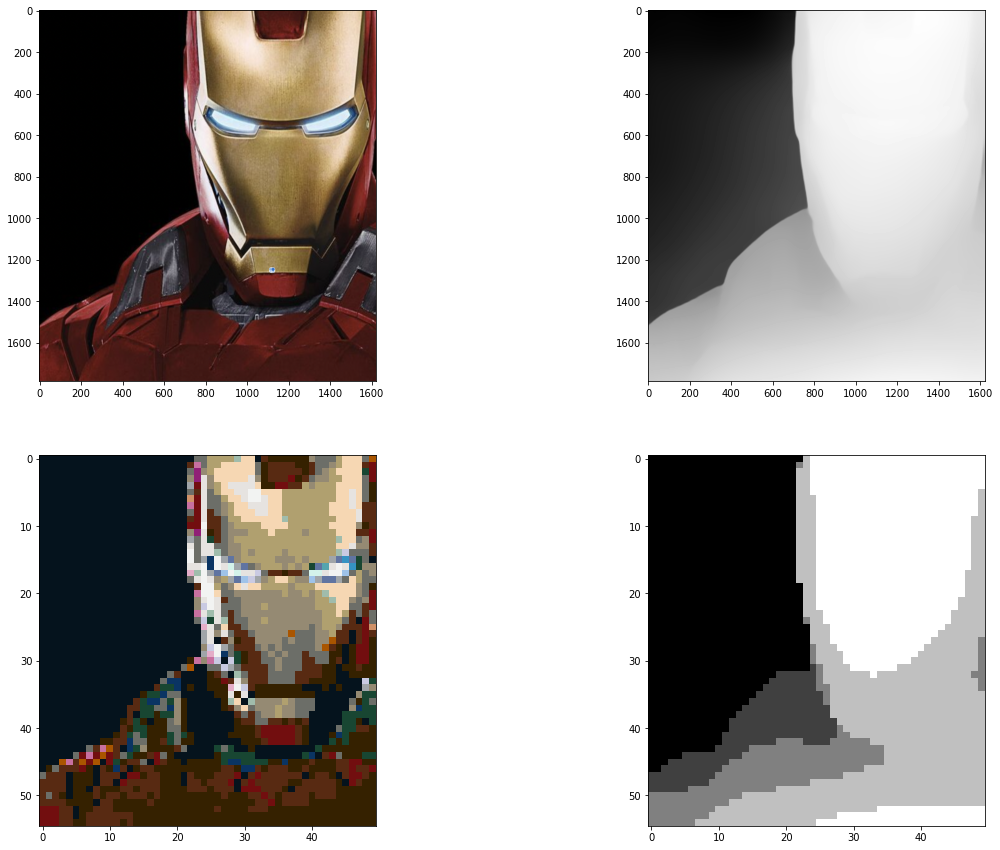

'npyファイルの保存'

In [11]:
image_original = cv2.imread("./data/img/ironman_rgb.png")
depth_map = cv2.imread("./data/img/ironman_depth.png", 0)
resize_w=50
block_h=5
lego_rgb, lego_depth, rgb_depth_array = main(image_original, depth_map, resize_w, block_h, COLOR_DIC)
show_col_list(COLOR_DIC)
show_image(image_original, depth_map, lego_rgb, lego_depth)
"""npyファイルの保存"""
#np.save("./data/npy/MM_depth", rgb_depth)

### 色を指定してアイアンマンを作成
0 1 5 6 8 9 16 17 21 23 28 29 31 32 33 34 44

{'0 White': [242, 243, 242], '1 Tan': [111, 160, 176], '2 Light Green': [168, 217, 173], '3 Maersk Blue': [195, 146, 53], '4 Pink': [255, 217, 171], '5 Nougat': [104, 145, 208], '6 Red': [9, 26, 201], '7 Blue': [191, 85, 0], '8 Yellow': [55, 205, 242], '9 Black': [29, 19, 5], '10 Green': [65, 120, 35], '11 Md,Green': [117, 196, 127], '12 Bt,Green': [65, 171, 88], '13 Dark Orange': [0, 85, 169], '14 Light Violet': [226, 202, 201], '15 Md,Blue': [219, 147, 90], '16 Md,Orange': [11, 167, 255], '17 Orange': [24, 138, 254], '18 Blue-Violet': [202, 116, 104], '19 Light Turquoise': [175, 165, 85], '20 Lime': [11, 233, 187], '21 Magenta': [118, 31, 144], '22 Sand Blue': [161, 116, 96], '23 Md,Nougat': [42, 112, 204], '24 Dark Tan': [115, 138, 149], '25 Dark Blue': [99, 52, 10], '26 Dark Green': [50, 70, 24], '27 Sand Green': [172, 188, 160], '28 Dark Red': [15, 14, 114], '29 Bt,Lt Orange': [61, 187, 248], '30 Reddish Brown': [18, 42, 88], '31 Light Bluish Gray': [169, 165, 160], '32 Dark Bluis

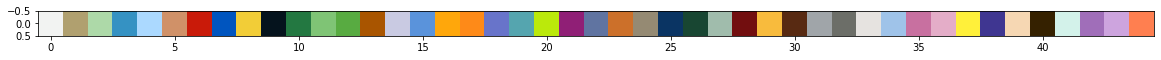

0 1 5 6 8 9 16 17 21 23 28 29 31 32 33 34 44


In [12]:
USE_COLOR_DIC = choose_color(COLOR_DIC)

libpng warning: extreme cHRM chunk cannot be converted to tristimulus values
libpng warning: Invalid cHRM red point


(55, 50, 3)
(55, 50, 1)


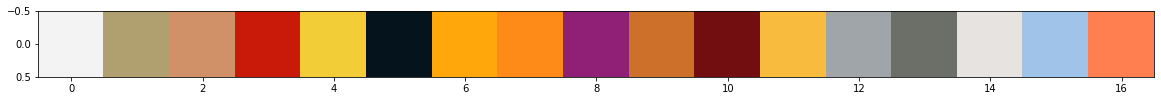

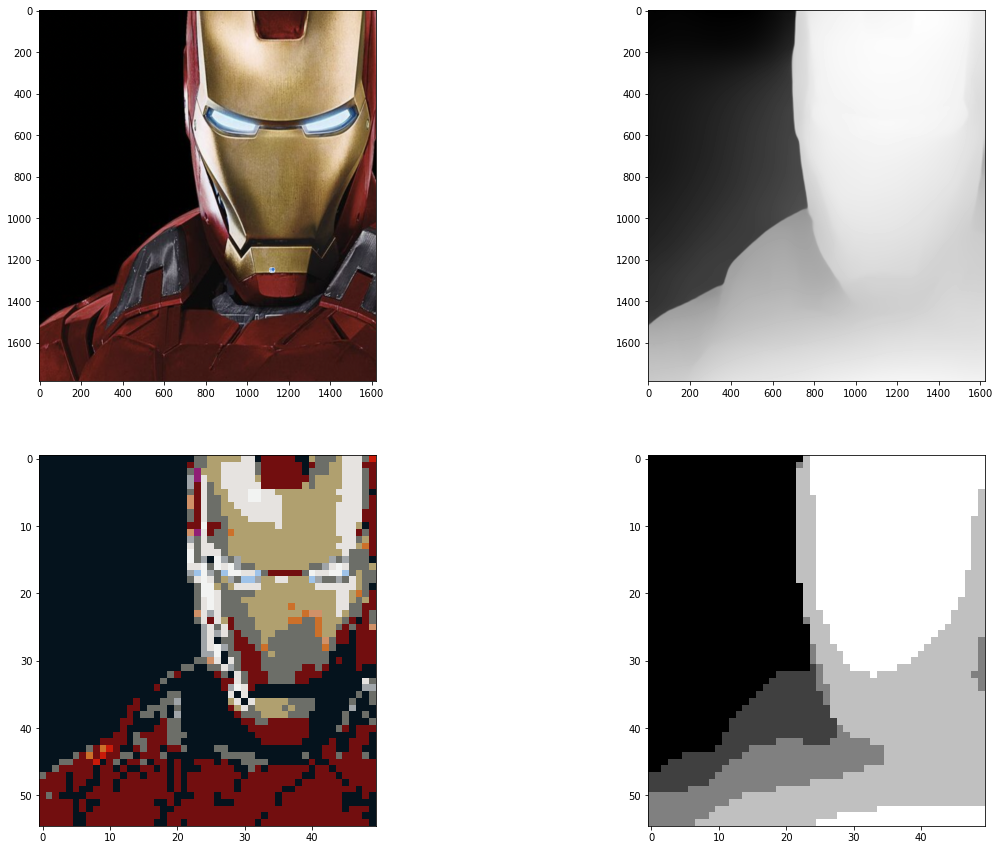

'npyファイルの保存'

In [13]:
image_original = cv2.imread("./data/img/ironman_rgb.png")
depth_map = cv2.imread("./data/img/ironman_depth.png", 0)
resize_w=50
block_h=5
lego_rgb, lego_depth, rgb_depth_array = main(image_original, depth_map, resize_w, block_h, USE_COLOR_DIC) #使用するブロックの色を指定
show_col_list(USE_COLOR_DIC)
show_image(image_original, depth_map, lego_rgb, lego_depth)
"""npyファイルの保存"""
#np.save("./data/npy/MM_depth", rgb_depth)

## 炭次郎

(112, 200, 3)
(112, 200, 1)


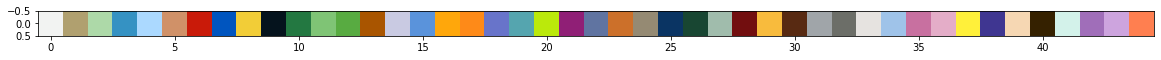

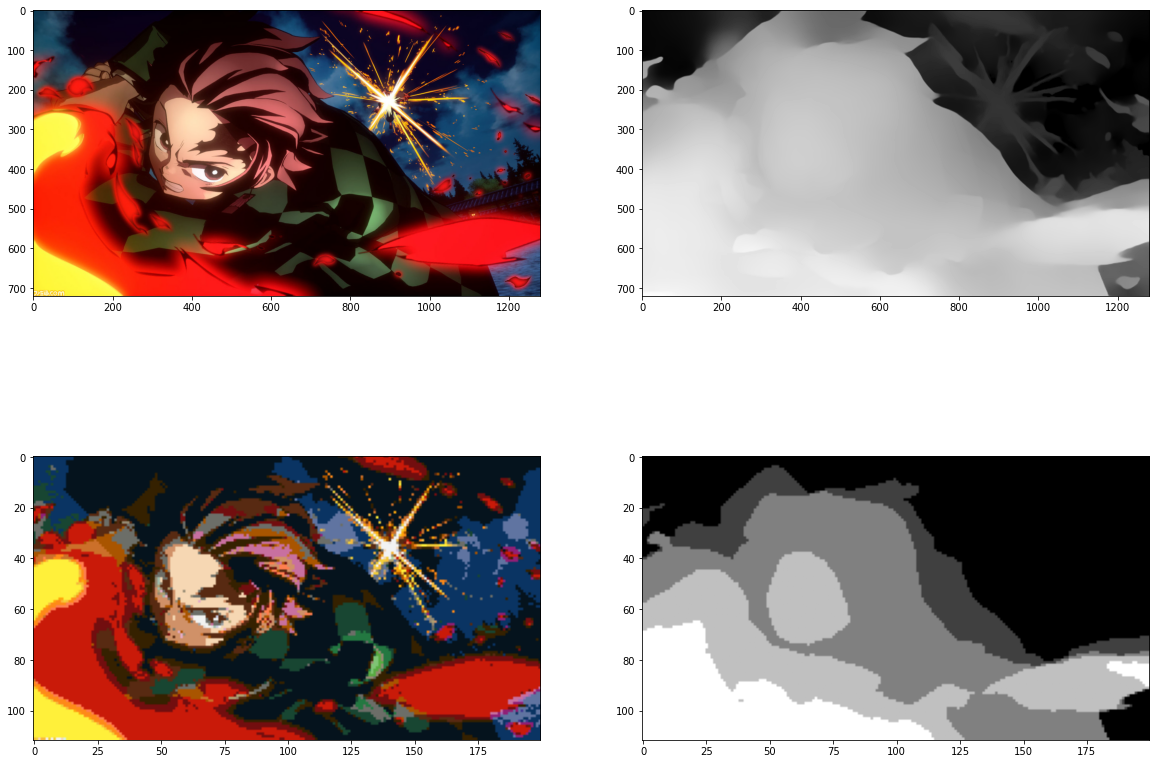

In [14]:
image_original = cv2.imread("./data/img/kamado_rgb.png")
depth_map = cv2.imread("./data/img/kamado_depth.png", 0)
resize_w=200
block_h=5
lego_rgb, lego_depth, rgb_depth_array = main(image_original, depth_map, resize_w, block_h, COLOR_DIC)
show_col_list(COLOR_DIC)
show_image(image_original, depth_map, lego_rgb, lego_depth)
"""npyファイルの保存"""
np.save("./data/npy/kamado", rgb_depth_array)